In [3]:
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm, trange

## Corpus for Retrieval

In [12]:
with open('../data/wikipedia_documents.json', "r", encoding="utf-8") as f:
    wiki = json.load(f)
    
wiki_corpus = list(
    dict.fromkeys([v["text"] for v in wiki.values()])
)

In [189]:
wiki['0']

{'text': '이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다.\n\n이 목록은 명료화를 위해 두 부분으로 나뉘어 있다.\n\n# 첫 번째 부분은 바티칸 시국과 팔레스타인을 포함하여 유엔 등 국제 기구에 가입되어 국제적인 승인을 널리 받았다고 여기는 195개 나라를 나열하고 있다.\n# 두 번째 부분은 일부 지역의 주권을 사실상 (데 팍토) 행사하고 있지만, 아직 국제적인 승인을 널리 받지 않았다고 여기는 11개 나라를 나열하고 있다.\n\n두 목록은 모두 가나다 순이다.\n\n일부 국가의 경우 국가로서의 자격에 논쟁의 여부가 있으며, 이 때문에 이러한 목록을 엮는 것은 매우 어렵고 논란이 생길 수 있는 과정이다. 이 목록을 구성하고 있는 국가를 선정하는 기준에 대한 정보는 "포함 기준" 단락을 통해 설명하였다. 나라에 대한 일반적인 정보는 "국가" 문서에서 설명하고 있다.',
 'corpus_source': '위키피디아',
 'url': 'TODO',
 'domain': None,
 'title': '나라 목록',
 'author': None,
 'html': None,
 'document_id': 0}

In [200]:
wiki_corpus = []
for i in range(len(wiki)):
    wiki_corpus.append(wiki[str(i)]['text'])
len(wiki_corpus)

60613

In [198]:
wiki_source = []
for i in range(len(wiki)):
    wiki_source.append(wiki[str(i)]['corpus_source'])

In [195]:
from collections import Counter

w = Counter(wiki_source)
print(len(wiki))
print(w)

60613
Counter({'위키피디아': 60613})


In [201]:
print('전체 위키 문서의 개수:', len(wiki_corpus))
print('중복 없는 위키 문서의 개수:', len(list(set(wiki_corpus))))

전체 위키 문서의 개수: 60613
중복 없는 위키 문서의 개수: 56737


In [23]:
doc_len = []
cnt=0
for doc in wiki_corpus:
    cnt+=1
    doc_len.append(len(doc))
cnt

56737

In [27]:
print('평균 document 길이:', np.mean(doc_len))
print('가장 긴 document 길이:', np.max(doc_len))
print('가장 짧은 document 길이:', np.min(doc_len))

평균 document 길이: 750.8205932636552
가장 긴 document 길이: 46099
가장 짧은 document 길이: 184


<AxesSubplot:>

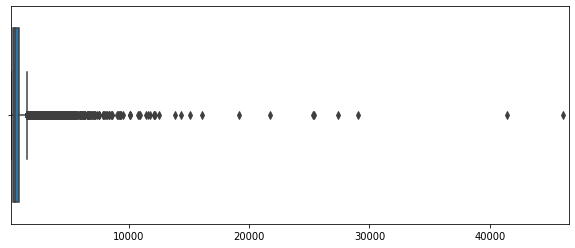

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.xlim(np.min(doc_len), np.max(doc_len)*1.01)
sns.boxplot(x=doc_len)

In [51]:
def outlier_iqr(x): 
    # lower, upper 글로벌 변수 선언하기     
    global lower, upper    
    
    # 4분위수 기준 지정하기     
    q25, q75 = np.quantile(x, 0.25), np.quantile(x, 0.75)          
    
    # IQR 계산하기     
    iqr = q75 - q25    
    
    # outlier cutoff 계산하기     
    cut_off = iqr * 1.5          
    
    # lower와 upper bound 값 구하기     
    lower, upper = q25 - cut_off, q75 + cut_off     
    
    print('IQR은',iqr, '이다.')     
    print('lower bound 값은', lower, '이다.')     
    print('upper bound 값은', upper, '이다.')    
    
    # 1사 분위와 4사 분위에 속해있는 데이터 각각 저장하기     
    data1 = [i for i in x if i > upper] 
    data2 = [i for i in x if i < lower]   
    print(len(data1), len(data2))
    # 이상치 총 개수 구하기
    return print('총 이상치 개수는', len(data1) + len(data2), '이다.')
# https://claryk.tistory.com/4

In [48]:
outlier_iqr(doc_len)

IQR은 440.0 이다.
lower bound 값은 -244.0 이다.
upper bound 값은 1516.0 이다.
3901 0
총 이상치 개수는 3901 이다.


전체 56737개 문서 중 이상치는 3901개임을 알 수 있다.

## Train,Validation Datasets

In [54]:
datasets = load_from_disk('../data/train_dataset')
datasets

DatasetDict({
    train: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 3952
    })
    validation: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 240
    })
})

In [91]:
datasets['train'][0]

{'title': '미국 상원',
 'context': '미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\\n\\n미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.\\n\\n미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05',
 'question': '대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?',
 'id': 'mrc-1-000067',
 'answers': {'answer_start'

### Context

In [77]:
train_contexts = datasets['train']['context']
valid_contexts = datasets['validation']['context']

In [78]:
print(len(train_contexts), len(valid_contexts))

3952 240


In [94]:
train_len = []
for doc in train_contexts:
    train_len.append(len(doc))

val_len = []
for doc in valid_contexts:
    val_len.append(len(doc))

In [80]:
train_len

array([ 862.,  621.,  850., ..., 1533., 1110.,  551.])

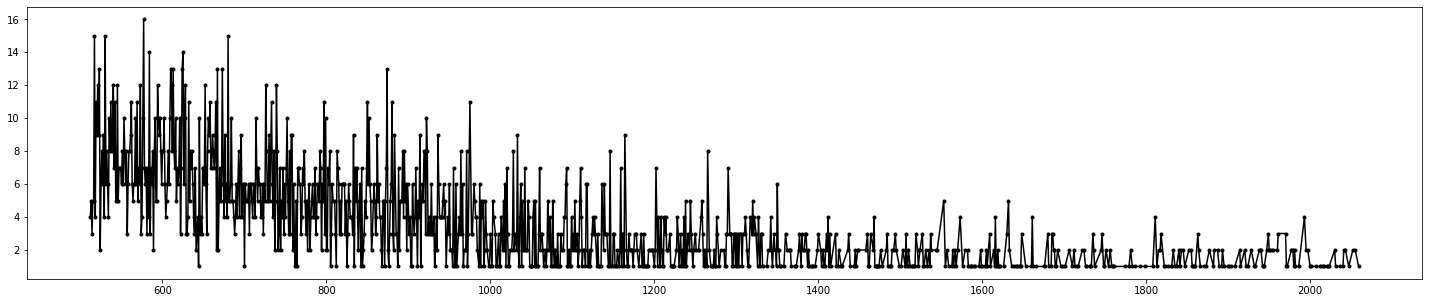

In [87]:
from collections import Counter

count_len = Counter(train_len)
count_len = sorted(count_len.items())
x = [x[0] for x in count_len]
y = [x[1] for x in count_len]

fig, ax = plt.subplots(1, 1, figsize=(25, 5))
ax.plot(x, y,
        color='black',
        marker='.',
        linestyle='solid', 
       )

plt.show()

<AxesSubplot:>

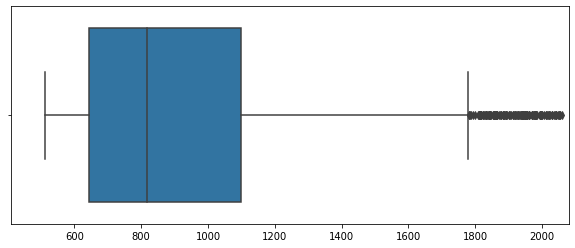

In [109]:
plt.figure(figsize=(10,4))
plt.xlim(np.min(train_len)*0.8, np.max(train_len)*1.01)
sns.boxplot(x=train_len)

In [95]:
print('평균 document 길이:', np.mean(train_len))
print('가장 긴 document 길이:', np.max(train_len))
print('가장 짧은 document 길이:', np.min(train_len))

평균 document 길이: 920.2206477732793
가장 긴 document 길이: 2059
가장 짧은 document 길이: 512


### Qustion

In [99]:
train_questions = datasets['train']['question']

In [101]:
train_q_len = []
for doc in train_questions:
    train_q_len.append(len(doc))

In [102]:
print('평균 document 길이:', np.mean(train_q_len))
print('가장 긴 document 길이:', np.max(train_q_len))
print('가장 짧은 document 길이:', np.min(train_q_len))

평균 document 길이: 29.32236842105263
가장 긴 document 길이: 78
가장 짧은 document 길이: 8


<AxesSubplot:>

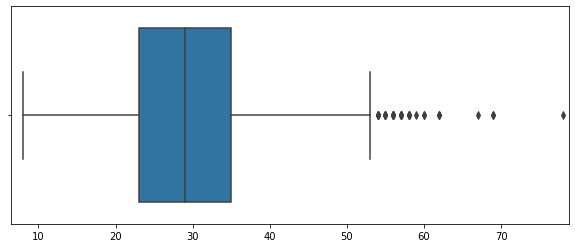

In [108]:
plt.figure(figsize=(10,4))
plt.xlim(np.min(train_q_len)*0.8, np.max(train_q_len)*1.01)
sns.boxplot(x=train_q_len)

In [114]:
long_idx = []
short_idx = []
for i in train_questions:
    if len(i) == 78:
        long_idx.append(i)
    elif len(i) == 8:
        short_idx.append(i)
print(long_idx)
print(short_idx)

['사전처분에도 불구하고 양육 부모가 비양육 부모에게 아이를 보여주지 않을 때 위반 행위자에게 1천만원 이하의 과태료를 부과할 수 있는 제도는?']
['연희의 직업은?', '훈다손의 뜻은?']


### Answer

In [127]:
train_answers = datasets['train']['answers']

In [139]:
print(train_answers[0])
print(train_answers[1])

{'answer_start': [235], 'text': ['하원']}
{'answer_start': [212], 'text': ['《경영의 실제》']}


In [160]:
train_answers_idx = []
train_answers_text = []
for i in train_answers:
    train_answers_idx.append(i['answer_start'][0])
    train_answers_text.append(i['text'][0])

In [166]:
train_answers_text[:5]

['하원', '《경영의 실제》', '백성', '중국', '4개']

In [162]:
train_a_len = []
for doc in train_answers_text:
    train_a_len.append(len(doc))

In [163]:
print('평균 answer 길이:', np.mean(train_a_len))
print('가장 긴 answer 길이:', np.max(train_a_len))
print('가장 짧은 answer 길이:', np.min(train_a_len))

평균 answer 길이: 6.275050607287449
가장 긴 answer 길이: 83
가장 짧은 answer 길이: 1


<AxesSubplot:>

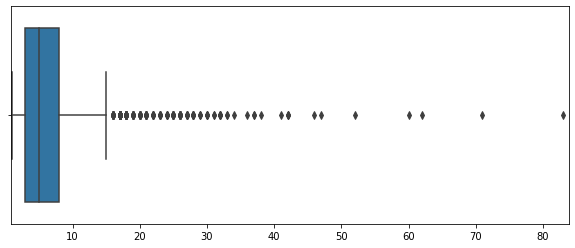

In [164]:
plt.figure(figsize=(10,4))
plt.xlim(np.min(train_a_len)*0.8, np.max(train_a_len)*1.01)
sns.boxplot(x=train_a_len)

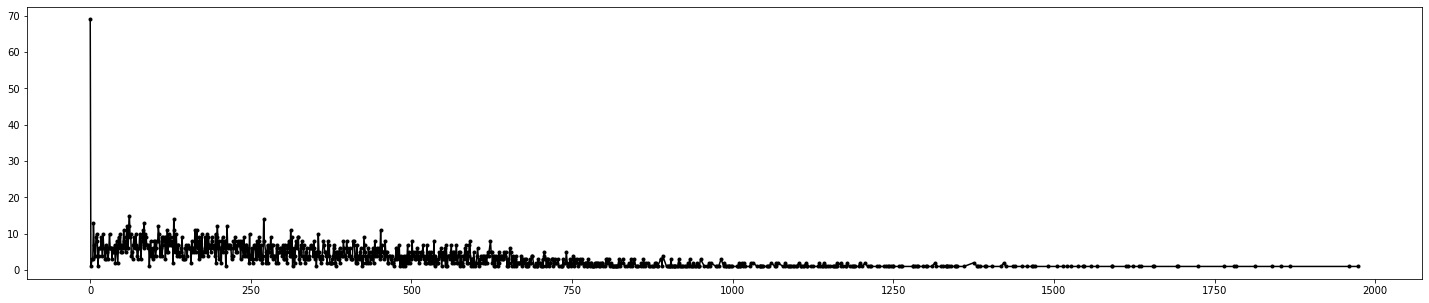

In [167]:
from collections import Counter

count_len = Counter(train_answers_idx)
count_len = sorted(count_len.items())
x = [x[0] for x in count_len]
y = [x[1] for x in count_len]

fig, ax = plt.subplots(1, 1, figsize=(25, 5))
ax.plot(x, y,
        color='black',
        marker='.',
        linestyle='solid', 
       )

plt.show()

대부분의 정답은 context의 앞부분에 위치해있다. 나중에 context의 문장의 순서를 섞어서 정답이 뒤에 나오더라도 맞출 수 있게 augmentation을 취하면 괜찮을 것 같다.

In [176]:
answer_0 = []
for i in range(len(train_answers_idx)):
    if train_answers_idx[i] == 0:
        answer_0.append(i)

In [177]:
datasets['train'][answer_0[0]]

{'title': '하프라이프의 등장인물 목록',
 'context': "그리고리 신부(Father Grigori)는 게임 하프라이프 2의 레이븐홈 챕터에서 등장하는 캐릭터이다.\\n\\n그리고리 신부는 원래 레이븐홈의 러시아 정교회 성당의 신부로 지내고 있었다.\\n\\n고든이 레이븐홈에 도착했을 당시, 그는 그때도 마을 분위기에 비해 상당히 깨끗한 청남색 신부복을 입고 금빛 십자가가 달린 목걸이를 하고 있었으며 대머리에 비해 대조적으로 덥수룩한 턱수염을 가지고 있었다.\\n\\n평범한 광산 마을을 가장하고 반군기지로서 존재하던 레이븐홈은 어느날 반군의 주둔 사실을 알아챈 콤바인의 헤드크랩을 담은 로켓의 폭격을 받아 그리고리 신부를 제외한 모든 사람이 헤드크랩에 물려 좀비가 되어 마을 안을 배회하게 되었다. 목숨을 부지한 그리고리 신부는 살아남기 위해 레이븐홈을 전전하며 좀비들을 '구원하기' 위한 수많은 인공 함정을 만들어놓고 그들을 레이븐홈 내에서 소탕하기 위해 계속해서 싸운다.\\n\\n그러던 와중 콤바인의 습격으로 인해 블랙 메사 동부에서 도망쳐왔던 고든 프리맨과 만나게 되고, 좀비와 헤드크랩을 쏴죽이거나 좀비를 상대로 강력한 위력을 발휘하는 산탄총을 던져주는 등, 여러 도움을 주며\\n고든이 끝까지 헤쳐나와 자신의 성당으로 오도록 유도한 후에 공동묘지에서 고든과 함께 윈체스터 장총으로 좀비들을 소탕하며 레이븐홈의 밖으로 나가는 곳으로 인도해준다.\\n\\n그를 볼 수 있는 마지막 장소인 광산 출구에서, 그는 불길 너머로 모여 드는 좀비들을 구원하며 광소(狂笑)와 함께 종적을 감춘다. 에피소드 1의 요새 붕괴로 인하여 17번 지구와 그 외곽이 방사능에 뒤덮임에 따라 그리고리 신부는 죽었을 것이라는 추측이 있지만 확실치는 않다.\\n\\n그리고 신부가 산탄총을 줄 때, 치트로 날아가면 신부의 총 에나벨을 얻을 수 있다.",
 'question': '고든 프리맨이 레이븐홈을 떠날 수 있도록 도와준 사람은?',
 'id': 'mrc-0-003332',
 'a

In [209]:
train_answer_idx_percent = []
for i in range(len(train_answers)):
    train_answer_idx_percent.append(train_answers_idx[i]/train_len[i])
train_answer_idx_percent[:10]

[0.27262180974477956,
 0.3413848631239936,
 0.6,
 0.859697386519945,
 0.04926108374384237,
 0.1344165435745938,
 0.08808290155440414,
 0.7144607843137255,
 0.2628032345013477,
 0.4715224534501643]

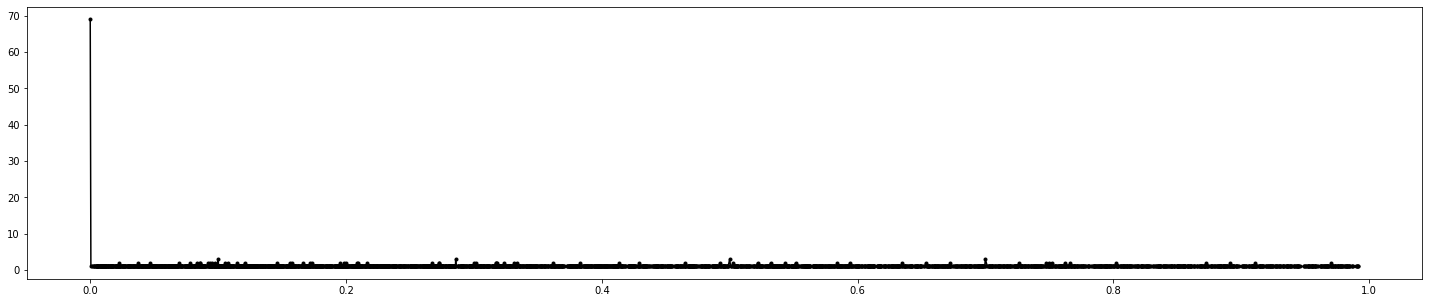

In [210]:
count_len = Counter(train_answer_idx_percent)
count_len = sorted(count_len.items())
x = [x[0] for x in count_len]
y = [x[1] for x in count_len]

fig, ax = plt.subplots(1, 1, figsize=(25, 5))
ax.plot(x, y,
        color='black',
        marker='.',
        linestyle='solid', 
       )

plt.show()

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

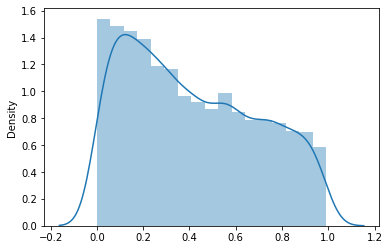

In [211]:
sns.distplot(train_answer_idx_percent)